In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

warnings.simplefilter("ignore")
%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("ggplot")

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

## 0.Data load

In [2]:
# # choongs load
# df_cust = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
# df_cop_u = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
# df_pd_clac = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

In [3]:
# ## osy load
# df_cust = pd.read_csv("../../LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../../LPOINT_BIG_COMP_02_PDDE.csv")
# df_cop_u = pd.read_csv("../../LPOINT_BIG_COMP_03_COP_U.csv")
# df_pd_clac = pd.read_csv("../../LPOINT_BIG_COMP_04_PD_CLAC.csv")

In [4]:
# rnch load
df_cust = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
df_pdde = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
df_cop_u = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
df_pd_clac = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

**RNCH Setting**

|Resource Name    |Specific Information                  |
|-----------------|--------------------------------------|
| CPU		      | Intel 12th 12600k                    |
| Memory          | Samsung DDR4-25600 32G (16G * 2)     |
| GPU             | Nvidia RTX 3070Ti DX8                |
| SSD1            | Samsung pm9a1 1TB                    |
| SSD2            | SK Hynix P31 Gold 500GB              |

# 1.Data Set Split Function

**함수 개요**
```python
def delete_outlier_DBSCAN(df_pdde, df_pd_clac)
```
- DBSCAN을 통한 이상치 탐지 (`eps` 선정 자동화)
- `df_pdde`: 상품 구매 정보, `df_pd_clac`: 상품 분류 정보
- return: 이상치가 제거된 고객ID Series
---

```python
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv")
```
- online 사용 / offline 사용 / on-offline 둘 다 사용한 고객을 구분하는 함수
- Merge 단계에서 구매가 없는 고객은 drop
- `df_main`: Merge 기준 DF, `df`: 고객, 채널을 포함하는 구매 정보 DF
- return: 고객 별 online(2), offline(1), on-offline(1,2) 로 구분된 DF
---

```python
def split_on_off(df, col_nm="chnl_dv")
```
- online 구매 경험이 있는 고객 / offline으로만 구매한 고객을 분할하는 함수
- `df`: 고객 별 online(2), offline(1), on-offline(1,2) 로 구분된 DF
- return: online 구매 경험이 있는 고객 / offline으로만 구매한 고객으로 구분된 DF
---

```python
def classification_buy_am(x, std_points)
```
- 소비 금액대 별로 구매 등급을 분할하는 함수
- `x`: Target 값, `std_points`: 등급을 분할하는 절단점 (list)
- return: Target값을 "A, B, C, D" 등급으로 변환한 값
---

```python
def split_buy_amount_by_4(df_main, df_sub, key='cust', col_nm='buy_am')
```
- 소비 금액대 별로 구매 등급을 분할하여 DF에 반영하는 함수
- `df_main`: Merge 기준이 되는 DF, `df_sub`: 구매 금액이 기술된 DF
- return: 구매 금액을 "A, B, C, D" 등급으로 변환한 DF
---
```python
def data_set_split(df_main, df_sub, not_outlier_cust)
```
- 위에 기술된 함수의 전과정을 분리된 데이터 세트 별로 실행하여 취합하는 함수
- `df_main`: Merge 기준이 되는 DF, `df_sub`: 구매 금액, 채널이 기술된 DF, `not_outlier_cust`: 이상치가 아닌 고객 정보가 반영된 list
- return: 밑의 표에 기술된 8개의 데이터 프레임

|군집 번호|채널   |금액 등급|
|:------:|:-----:|:------:|
|0       |Offline|A       |
|1       |Offline|B       |
|2       |Offline|C       |
|3       |Offline|D       |
|4       |Online |A       |
|5       |Online |B       |
|6       |Online |C       |
|7       |Online |D       |

In [31]:
# DBSCAN을 통해 이상치 제거
def delete_outlier_DBSCAN(df_pdde, df_pd_clac):
    df_pdde_pd_clac = df_pdde.merge(df_pd_clac, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
               values='buy_am',
               index='cust',
               columns='clac_hlv_nm',
               aggfunc='sum',
               fill_value=0)
    df_pt.reset_index(inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()

    # eps 탐색
    eps_ratio_outlier_dict = dict()
    for epss in tqdm(list(np.arange(0.05, 0.15, 0.01))):
        dbscan = DBSCAN(eps = epss, min_samples = 30, metric = "euclidean")
        dbscan_labels = dbscan.fit_predict(df_spt_2.iloc[:, 1:])
        ratio_outlier = np.unique(dbscan_labels, return_counts=True)[1][0]/np.unique(dbscan_labels, return_counts=True)[1].sum()
        eps_ratio_outlier_dict[epss] = abs(ratio_outlier-0.05) #딕셔너리 Value는 이상치-0.05의 절댓값 -> 즉 0.05에 가장 가까운 값을 찾는다.

    best_eps = min(eps_ratio_outlier_dict,key=eps_ratio_outlier_dict.get)
    

    dbscan = DBSCAN(eps = best_eps, min_samples = 30, metric = "euclidean")
    dbscan_labels = dbscan.fit_predict(df_spt_2.iloc[:, 1:])
    df_spt_2['outlier'] = dbscan_labels

    df_spt_not_outlier_cust = df_spt_2[df_spt_2['outlier']==0]['cust']
    
    return df_spt_not_outlier_cust



# 누락 데이터 삭제
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv"):
    df_new = pd.DataFrame(df.groupby(key)[col_nm].apply(lambda x:list(set(x))))
    return df_main.merge(df_new, how="left", on=key).dropna(subset=["chnl_dv"])



# on/off 분류
def split_on_off(df, col_nm="chnl_dv"):
    df[col_nm] = df[col_nm].apply(lambda x: x[0] if len(x)==1 else 0)
    df_off = df.loc[df[col_nm]==1] ##off
    df_on = df.loc[df[col_nm]==2] ##on
    df_onf = df.loc[df[col_nm]==0] ##onf

    df_not_off = pd.concat([df_on, df_onf], axis=0, ignore_index=True)


    return df_off, df_not_off #off, not_off

def classification_buy_am(x, std_points):
    if x <= std_points[0]:
        return "D"
    elif std_points[0] < x <= std_points[1]:
        return "C"
    elif std_points[1] < x <= std_points[2]:
        return "B"
    else:
        return "A"

def split_buy_amount_by_4(df_main, df_sub, key='cust', col_nm='buy_am'):
    df_new = df_sub.groupby([key], as_index=False)[col_nm].sum()
    df_new2 = df_main.merge(df_new, on='cust', how='left')
    df_new2["am_class"] = df_new2[col_nm].apply(classification_buy_am, std_points=np.quantile(df_new2[col_nm], [.25, .5, .75]))
    

    df_A = df_new2[df_new2['am_class']=='A']
    df_B = df_new2[df_new2['am_class']=='B']
    df_C = df_new2[df_new2['am_class']=='C']
    df_D = df_new2[df_new2['am_class']=='D']
    
    return df_A, df_B, df_C, df_D
    

# def domain_clustering_ver2(df_main, df_sub, df_sub2):
def data_set_split(df_main, df_sub, not_outlier_cust):

    # not_outlier_cust = delete_outlier_DBSCAN(df_sub, df_sub2)

    df_main = df_main.loc[df_main['cust'].isin(not_outlier_cust.values.tolist())]

    df = check_on_off(df_main, df_sub)

    df_off, df_not_off= split_on_off(df)

    
    df_off_A, df_off_B, df_off_C, df_off_D  = split_buy_amount_by_4(df_off, df_sub)
    df_not_off_A, df_not_off_B, df_not_off_C, df_not_off_D  = split_buy_amount_by_4(df_not_off, df_sub)

    df_off_A['cluster'] = 0
    df_off_B['cluster'] = 1
    df_off_C['cluster'] = 2
    df_off_D['cluster'] = 3
    df_not_off_A['cluster'] = 4
    df_not_off_B['cluster'] = 5
    df_not_off_C['cluster'] = 6
    df_not_off_D['cluster'] = 7

    df_off_A_label = df_off_A[['cust', 'cluster']]
    df_off_B_label = df_off_B[['cust', 'cluster']]
    df_off_C_label = df_off_C[['cust', 'cluster']]
    df_off_D_label = df_off_D[['cust', 'cluster']]
    df_not_off_A_label = df_not_off_A[['cust', 'cluster']]
    df_not_off_B_label = df_not_off_B[['cust', 'cluster']]
    df_not_off_C_label = df_not_off_C[['cust', 'cluster']]
    df_not_off_D_label = df_not_off_D[['cust', 'cluster']]
    

        
    return df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label

In [33]:
df_not_outlier = delete_outlier_DBSCAN(df_pdde, df_pd_clac)
df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label = data_set_split(df_cust, df_pdde, df_not_outlier) 

  0%|          | 0/10 [00:00<?, ?it/s]

# 2.K means Clustering Function

In [34]:
# 분할 데이터 셋을 하나로 병합
df_list = [df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label]
df_dom_clustered = pd.concat(df_list, ignore_index=True)

In [35]:
# 구매 내역과 상품 정보 병합
df_main = pd.merge(df_pdde, df_pd_clac, how='left', on='pd_c')

**함수 개요**

```python
def merging(df1, df2)
```
- 고객을 기준으로 merge하는 pandas.merge() 함수를 간략히 하기 위해 기술
- `df1`: Merge 기준이 되는 DF, `df2`: Merge 당하는 DF
- return: pd.merge(df1, df2, on="cust", how="left")
---
```python
def pivoting(df_main, df)
```
- 고객이 어떤 상품에 얼마나 소비했는지 보기 위한 pivoting을 수행하고 Min-Max Scaling하는 함수
- `df_main`: 구매정보와 상품 대분류명이 포함된 전체 DF, `df`: 클러스터 별로 분리된 구매정보-상품 대분류명이 포함된 DF
- return: 스케일링된 Index-"cust", Columns-"clac_hlv_nm", Values-"buy_am"의 Pivot Table
---
```python
def get_inertia(df, k)
```
- 최적 군집 개수 선택 시 사용하는 Inertia Method를 사용하기 위한 k별 inertia 도출 함수
- `df`: 군집화 대상 DF, `k`: 군집 개수
- return: 군집 개수에 따른 군집화 대상의 inertia
---
```python
def get_clusters_k(df)
```
- 최적 군집 개수 선택을 위해 기술된 함수
- `df`: 군집화 대상 DF
- return: 최적 군집 개수
---
```python
def clustering(df_main, df_dom_clustered)
```
- 위의 과정에서 분할된 8개의 데이터 셋에 대해, 각 데이터 셋을 독립적으로 군집화하여 최종 군집을 도출하는 함수
- `df_main`: 구매 내역과 상품 정보 병합된 DF, `df_dom_clustered`: 상기 실행 과정의 결과로 도출된 8개로 분류된 DF를 Concat한 DF
- return: 고객ID와 최종 군집 label이 포함된 DF


In [38]:
def merging(df1, df2):
    return pd.merge(df1, df2, how='left', on='cust')


def pivoting(df_main, df): 
    columns_default = list(df_main['clac_hlv_nm'].unique())
    df_res = pd.DataFrame(columns=columns_default)
    df_pt = pd.pivot_table(data=df,
                           values='buy_am',
                           index='cust',
                           columns='clac_hlv_nm',
                           aggfunc='sum',
                           fill_value=0)
    df_res = pd.concat([df_res, df_pt], ignore_index=False)
    df_res.fillna(0, inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_res)
    df_spt = pd.DataFrame(scaler.transform(df_res), index=df_pt.index, columns=df_res.columns)
    return df_spt


def get_inertia(df, k):
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(df)
    return Kmeans.inertia_

def get_clusters_k(df):
    k_range = range(2, 20)
    k_result = None

    for k in k_range:
        minus = get_inertia(df, k) - get_inertia(df, k + 1)
        if k == 2:
            minus_before = minus
            minus_rate_max = 0
        else:
            minus_rate = minus_before - minus
            if minus_rate > minus_rate_max:
                k_result = k
                minus_rate_max = minus_rate
            minus_before = minus

    return k_result


def clustering(df_main, df_dom_clustered):
    df = merging(df_main, df_dom_clustered)
    df_result = pd.DataFrame()
    db_clustered_k = len(df_dom_clustered['cluster'].unique())
    for i in range(db_clustered_k):
        df_ = df[df['cluster']==i]
        df_pt = pivoting(df_main, df_)
        k = get_clusters_k(df_pt)
        Kmeans_ = KMeans(n_clusters=k, random_state=200)
        Kmeans_.fit(df_pt)
        cluster = Kmeans_.predict(df_pt)
        df_pt['buy_am_cluster'] = cluster
        
        ### 최소 군집 수가 이뤄지지 않으면 버리기 ###
        result_srs = (df_pt["buy_am_cluster"].value_counts() >= 4)
        clusters = []
        for idx in result_srs.index:
            if result_srs[idx]:
                clusters.append(idx)
        df_pt = df_pt.loc[df_pt["buy_am_cluster"].isin(clusters)]
        ##########################################
        
        df_result = pd.concat([df_result, df_pt])
        # break
    df_result.fillna(0, inplace=True)
    df_result.reset_index(drop=False, inplace=True)
    df_result = df_result.merge(df_dom_clustered, how="left", on="cust")
    df_clustered_final = df_result.loc[:, ['cust', 'buy_am_cluster', 'cluster']]
    comb_cluster = df_clustered_final.iloc[:,1].astype(str)+df_clustered_final.iloc[:,2].astype(str)
    df_clustered_final["comb_cluster"] = comb_cluster.apply(lambda x: comb_cluster.unique().tolist().index(x))
    
    return df_clustered_final

In [39]:
# 군집화 전 과정 실행
df_clustering = clustering(df_main, df_dom_clustered)

In [40]:
# 군집화 결과 군집 별 고객 수 확인
df_clustering["comb_cluster"].value_counts()

0     2689
22    2410
14    1572
47    1559
3     1207
      ... 
29     107
24      98
31      92
30      76
13      55
Name: comb_cluster, Length: 49, dtype: int64

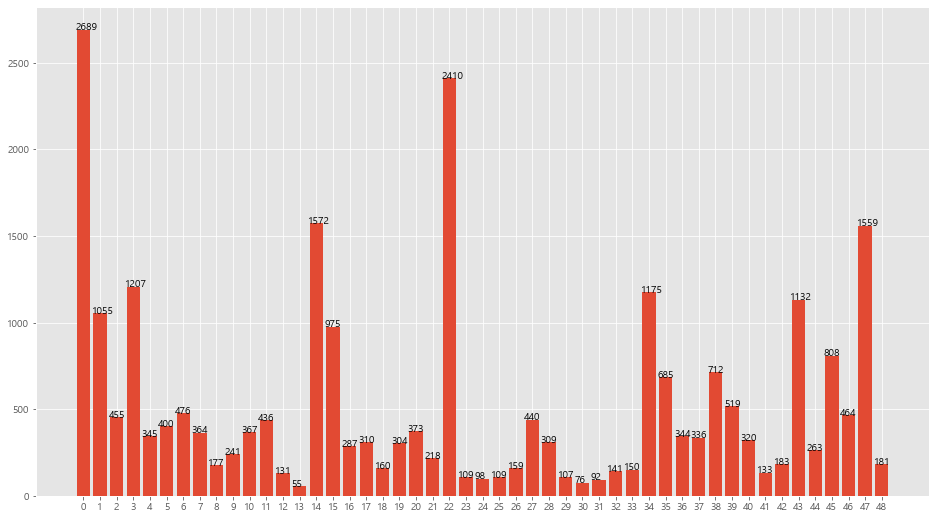

In [41]:
# 군집 별 고객 수 시각화
plt.bar(x=df_clustering["comb_cluster"].value_counts().index, height=df_clustering["comb_cluster"].value_counts().values)
for x in range(0,len(df_clustering["comb_cluster"].value_counts())):
    plt.text(x=x-.5, y=df_clustering["comb_cluster"].value_counts()[x],s=f"{df_clustering['comb_cluster'].value_counts()[x]}")
plt.xticks(range(0,len(df_clustering["comb_cluster"].value_counts())))
plt.show()

In [ ]:
# # 군집화 결과 저장
# df_clustering.to_csv("./predict_result/clustering_result.csv",index=False)

# 3.Recommend

**함수 개요**

```python
def pivot_table_for_recommend(df_pd, df_pdc, not_outlier_srs)
```
- 고객 간 거리 측정을 위해 상품 구매 정보, 상품 대분류를 통해 Pivoting, 상기 [이상치 제거](#1data-set-split-function) 과정에서 도출된 정상 범주 데이터만을 활용
- `df_pd`: 상품 구매 정보 DF (PDDE), `df_pdc`: 상품 정보 (PD_CLAC), `not_outliers_srs`: 이상치가 아닌 고객ID Series
- return: Index-"cust", Columns-"clac_hlv_nm", Values-"buy_am"이고, 이상치가 제거된 Pivot Table
---
```python
def min_max_pred(df_pt)
```
- 독립적인 Min-Max Scaling을 위한 간소화 함수
- `df_pt`: 스케일링을 수행할 DF
- return: 스케일링이 완료된 DF
---
```python
def find_nearest_3(df_clust, df_dist, clust_no, opt_test=None)
```
- 가장 가까운 3명의 이웃을 찾는 함수
- `df_clust`: 고객ID와 군집 정보가 포함된 DF, `df_dist`: `pviot_table_for_recommend`에서 추출된 pivot table, `clust_no`: 기준이 되는 클러스터 번호, 
- return: Index-"cust"로 하고 가장 가까운 세 명의 고객을 컬럼으로 하는 DF
---
```python
def code_to_name(df :pd.DataFrame, col_name :str, df_pdc :pd.DataFrame)
```
- 상품 코드를 상품명으로 변경해주는 함수
- `df`: 상품 코드가 있는 DF, `col_name`: 상품 코드를 갖는 컬럼의 이름, `df_pdc`: 상품 코드와 이름을 갖는 DF
- return: 상품 코드가 상품명으로 변경된 DF
---
```python
def make_cust_recommend_item(df_near, df_pd, df_pdc, opt_pd_nm=True)
```
- 가장 가까운 3명의 이웃의 구매 정보를 바탕으로 5개의 상품을 추천하는 함수
- `df_near`: `find_nearest_3`에서 추출된 가까운 3명 고객이 있는 DF, `df_pd`: 전체 상품 구매 정보 DF (PDDE), `df_pdc`: 상품 정보를 담고 있는 DF (PD_CLAC)
- return: 고객별 추천된 5개 상품이 포함된 DF와 예외 처리된 list 두 가지 리턴

In [50]:
# 함수화
import copy
from tqdm.notebook import tqdm

# 구매 내역과 상품 정보 pivoting
def pivot_table_for_recommend(df_pd, df_pdc, not_outlier_srs):
    df_norm = df_pd.loc[df_pd["cust"].isin(not_outlier_srs.values)]
    df_pdde_pd_clac = df_norm.merge(df_pdc, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
                values='buy_am',
                index='cust',
                columns='clac_hlv_nm',
                aggfunc='sum',
                fill_value=0)

    df_pt.reset_index(inplace=True)
    return df_pt

# Min-Max Scaling을 한 과정으로 진행
def min_max_pred(df_pt):
    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()
    return df_spt_2


# 가장 가까운 3명의 이웃을 탐색
def find_nearest_3(df_clust, df_dist, clust_no, opt_test=None):
    
    clust_list = df_clust.loc[df_clust["comb_cluster"]==clust_no]["cust"].values.tolist()
    df_similar = df_dist.loc[df_dist["cust"].isin(clust_list)]
    # Min Max Scaling
    df_norm_similar = min_max_pred(df_similar)

    dist_map = cdist(df_norm_similar.iloc[:,1:], df_norm_similar.iloc[:,1:], metric='cosine')   # scipy.spatial.dist.cdist를 통해 군집 내 고객들의 모든 거리 측정, Cosine 유사도
    near_indexes = dist_map.argsort()[:,1:4]    # argsort로 가장 가까운 3명의 인덱스 추출 (0번 인덱스는 무조건 자기 자신이기 때문에)
    near_loc_idx = [list(map(lambda x: df_norm_similar.iloc[x,0], near_idx)) for near_idx in near_indexes]
    df_near = pd.DataFrame(near_loc_idx, index=df_norm_similar["cust"].values)

    return df_near

# 상품 코드를 상품명으로 변환하는 함수
def code_to_name(df :pd.DataFrame, col_name :str, df_pdc :pd.DataFrame):
    df_result = copy.deepcopy(df)
    matching_series = df_pdc.set_index("pd_c")
    df_result[col_name] = df[col_name].apply(lambda x: matching_series.loc[x, "pd_nm"])
    return df_result

# 가장 가까운 3명의 이웃 구매 정보를 탐색하고 5가지 상품을 추천하는 함수
def make_cust_recommend_item(df_near, df_pd, df_pdc, opt_pd_nm=True):
    
    recommend_dict = {}
    except_list = []

    for cust_num in df_near.index:
    # sample은 이웃의 모든 구매 목록 리스트
        sample = df_pd.loc[df_pd["cust"].isin(df_near.loc[cust_num,:].tolist())]['pd_c'].value_counts()

    # sample_result는 이웃의 모든 구매 목록 리스트와 Target의 구매 목록 리스트를 비교해 Target이 구매하지 않은 품목을 찾음
        sample_result = set(sample.index)-set(df_pd.loc[df_pdde['cust']==cust_num]['pd_c'].values)

        df_smp = pd.DataFrame()
        df_smp["neighbor_list"] = list(sample_result)
        df_smp["neighbor_buy_am"] = list(map(lambda x: sample[x] ,list(sample_result)))
        if opt_pd_nm:
            df_smp_nm = code_to_name(df_smp.sort_values("neighbor_buy_am", ascending=False), "neighbor_list", df_pdc)
        else:
            df_smp_nm = copy.deepcopy(df_smp)
        
        # 혹시 발생할 수 있는 Indexing 오류에 대비한 try-except문
        try:
            sample_dff = df_smp_nm.iloc[:5,0].values.tolist()
            recommend_dict[cust_num] = sample_dff
        except:
            except_list.append((cust_num,len(df_smp_nm.iloc[:,0].values)))
            continue

    final_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in recommend_dict.items() ]))
    final_df = final_result_df.T

    return final_df, except_list

In [52]:
df_dist = pivot_table_for_recommend(df_pdde, df_pd_clac, df_not_outlier)

In [55]:
cluster_recommend_dict = dict()
cluster_exception = dict()

for clust_no in tqdm(df_clustering["comb_cluster"].unique()):
    near_3cust = find_nearest_3(df_clustering, df_dist, clust_no)
    cluster_recommend_dict[clust_no], cluster_exception[clust_no] = make_cust_recommend_item(near_3cust, df_pdde, df_pd_clac, True)
    
c_rd = copy.deepcopy(cluster_recommend_dict)
c_ex = copy.deepcopy(cluster_exception)

  0%|          | 0/49 [00:00<?, ?it/s]

In [56]:
import pickle
from datetime import datetime

with open("./predict_result/recommend_result_cluster_dict.pickle", "wb") as f:
    pickle.dump(c_rd, f, pickle.HIGHEST_PROTOCOL)
    
with open("./predict_result/exception_result_cluster_list.pickle", "wb") as f:
    pickle.dump(c_ex, f, pickle.HIGHEST_PROTOCOL)

In [57]:
c_rd[48]

0                 1                 2            3  \
M002867247   남성스포츠점퍼/재킷         남성등산점퍼/재킷               NaN          NaN   
M009682567     기타남성의류세트  남성스포츠스웨트셔츠/후드/집업            여성속옷세트          일반미   
M017524395       여성일반지갑              야구모자           캐쥬얼크로스백    여성등산티셔츠/탑   
M025168868      기타생활서비스            국물용기라면              감자스낵          일반빵   
M035670981        옥수수스낵             봉투보증금              일반스낵           콜라   
...                 ...               ...               ...          ...   
M977028904          즉석죽          기타남성의류세트              베이커리  영화/문화모바일상품권   
M983457029     기타남성의류세트        스파/워터파크이용권            남성남방셔츠      남성골프티셔츠   
M995885121      남성골프티셔츠                식빵              국산맥주         일반소주   
M998129365  유아동런닝/트레이닝화            기타등산용품              남성팬티    성인이불/이불커버   
M998600186       남성스니커즈              여성플랫  남성스포츠스웨트셔츠/후드/집업         여성샌들   

                     4  
M002867247         NaN  
M009682567   냉장핫도그/핫바류  
M017524395      남성등산바지  
M025168868         사이다  
M035670981      남아의류세트  
...                ...  
M977028904        샐러드류  
M983457029        남성코트  
M995885121        일반계란  
M998129365  스케이트보드/킥보드  
M998600186  실내액세서리편의용품  

[181 rows x 5 columns]

In [58]:
c_rd[0]

0          1        2            3        4
M000261625         쿠키       커피음료     동남아식           생수     스틱과자
M000350564   기타남성의류세트      봉투보증금   기타패션잡화     여성골프의류세트   골프필드용품
M000508243       국산담배   기타남성의류세트     수입담배      여성티셔츠/탑    스포츠음료
M001694463      남성티셔츠     기타전통과자      디저트     기타남성의류세트   기타온장조리
M001697472       국산담배       샐러드류    스킨/토너    기타파티/팬시용품     일반계란
...               ...        ...      ...          ...      ...
M997957983       임대매출     푸드코트한식  여아티셔츠/탑           일식     국산담배
M998346579       커피음료        디저트   국물봉지라면           콜라  냉장커피차음료
M999227380    여성티셔츠/탑        다기류   국물용기라면    냉장핫도그/핫바류   거실수예소품
M999340261  기타모바일액세서리  기타컴퓨터액세서리      키보드  기타아웃도어/레저용품       체리
M999673157       볶음반찬      일반차음료       한식       국물용기라면   생선선물세트

[2689 rows x 5 columns]

# 4.Concat result

In [59]:
pd.concat(c_rd.values(), axis=0).to_csv("./predict_result/recommend_result.csv", encoding="euc-kr")